In [3]:
#Import necessary Libraries:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources

nltk.download('punkt')
nltk.download('stopwords')

# Load the 'Fake.csv' and 'True.csv' datasets

fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

# Text Processing

# 1. Lowercasing
fake_df['text'] = fake_df['text'].str.lower()
real_df['text'] = real_df['text'].str.lower()  



# 2. Tokenization

fake_df['text'] = fake_df['text'].apply(nltk.word_tokenize)
real_df['text'] = real_df['text'].apply(nltk.word_tokenize)

# 3. Stop Word Removal

stop_words = set(stopwords.words('english'))
fake_df['text'] = fake_df['text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
real_df['text'] = real_df['text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# 4. Punctuation Removal

fake_df['text'] = fake_df['text'].apply(lambda tokens: [re.sub(r'[^\w\s]', '', word) for word in tokens])
real_df['text'] = real_df['text'].apply(lambda tokens: [re.sub(r'[^\w\s]', '', word) for word in tokens])

# 5. HTML Tag Removal (if applicable)

fake_df['text'] = fake_df['text'].apply(lambda tokens: [re.sub(r'<[^>]+>', '', word) for word in tokens])
real_df['text'] = real_df['text'].apply(lambda tokens: [re.sub(r'<[^>]+>', '', word) for word in tokens])

# 6. Numbers Removal
fake_df['text'] = fake_df['text'].apply(lambda tokens: [re.sub(r'\d+', '', word) for word in tokens])
real_df['text'] = real_df['text'].apply(lambda tokens: [re.sub(r'\d+', '', word) for word in tokens])

# 7. Stemming or Lemmatization
stemmer = PorterStemmer()
fake_df['text'] = fake_df['text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
real_df['text'] = real_df['text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# 8. Removing Non-Alphanumeric Characters
fake_df['text'] = fake_df['text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', word) for word in tokens])
real_df['text'] = real_df['text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', word) for word in tokens])


# 10. Feature Engineering (TF-IDF vectorization as an example)
tfidf_vectorizer = TfidfVectorizer()
fake_df['text'] = fake_df['text'].apply(lambda tokens: ' '.join(tokens))
real_df['text'] = real_df['text'].apply(lambda tokens: ' '.join(tokens))
fake_tfidf = tfidf_vectorizer.fit_transform(fake_df['text'])
real_tfidf = tfidf_vectorizer.fit_transform(real_df['text'])

# Dataset After Preprocessing:
print(fake_df.head(2))
print(real_df.head(2))

[nltk_data] Downloading package punkt to C:\Users\Gokul
[nltk_data]     Shreshta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gokul
[nltk_data]     Shreshta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  donald trump wish american happi new year leav...    News   
1  hous intellig committe chairman devin nune go ...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  washington  reuter   head conserv republican f...  politicsNews   
1  washington  reuter   transgend peopl allow fir...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   


In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [9]:
combined_df = pd.concat([fake_df, real_df], ignore_index=True)

In [10]:
# Create a new 'label' column and assign values
combined_df['label'] = 1  # 1 represents real news
combined_df.loc[fake_df.index, 'label'] = 0  # 0 represents fake news

In [11]:
X = combined_df['text'].values 
y = combined_df['label'].values 
 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, 
random_state=42) 
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, 
test_size=0.5, random_state=42)

In [2]:
bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained( 
    bert_name, 
    padding="max_length", 
    do_lower_case=True, 
    add_special_tokens=True, 
)

In [13]:
X_train_encoded = tokenizer( 
    X_train.tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors="tf", 
    max_length=128,  # Adjust the max sequence length as needed 
    return_token_type_ids=False, 
    return_attention_mask=True, 
).input_ids 
 
X_valid_encoded = tokenizer( 
    X_valid.tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors="tf", 
    max_length=128, 
    return_token_type_ids=False, 
    return_attention_mask=True, 
).input_ids 
 
X_test_encoded = tokenizer( 
    X_test.tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors="tf", 
    max_length=128, 
    return_token_type_ids=False, 
    return_attention_mask=True, 
).input_ids

In [17]:
# Create TensorFlow Datasets 
 
train_ds = tf.data.Dataset.from_tensor_slices((X_train_encoded, 
y_train)).shuffle(len(X_train)).batch(25).prefetch(tf.data.AUTOTUNE) 
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_encoded, 
y_valid)).shuffle(len(X_valid)).batch(25).prefetch(tf.data.AUTOTUNE) 
test_ds = tf.data.Dataset.from_tensor_slices((X_test_encoded, 
y_test)).shuffle(len(X_test)).batch(25).prefetch(tf.data.AUTOTUNE)

In [18]:
# Initialize the BERT model for binary classification 
 
bert_model = TFAutoModelForSequenceClassification.from_pretrained(bert_name, 
num_labels=1)  # Binary classification 
 
# Compile the model 
bert_model.compile( 
    optimizer=Adam(learning_rate=1e-5), 
    loss='binary_crossentropy',  # Use binary cross-entropy 
    metrics=[ 
        tf.keras.metrics.BinaryAccuracy(name="Accuracy"), 
        tf.keras.metrics.Precision(name="Precision"), 
        tf.keras.metrics.Recall(name="Recall"), 
    ] 
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Training 
num_epochs = 5  # Adjust as needed 
MODEL_CALLBACKS = []  # Add any callbacks you need 
batch_per_epoch=100

model_history = bert_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=num_epochs, 
    steps_per_epoch=batch_per_epoch,
    batch_size=16, 
    callbacks=MODEL_CALLBACKS 
)

Epoch 1/5
100/100 [==============================] - 1882s 19s/step - loss: 0.5402 - Accuracy: 0.7468 - Precision: 0.7809 - Recall: 0.6658 - val_loss: 0.3871 - val_Accuracy: 0.8094 - val_Precision: 1.0000 - val_Recall: 0.6004
Epoch 2/5
100/100 [==============================] - 1770s 18s/step - loss: 0.1387 - Accuracy: 0.9548 - Precision: 0.9866 - Recall: 0.9183 - val_loss: 0.0302 - val_Accuracy: 0.9947 - val_Precision: 0.9894 - val_Recall: 0.9995
Epoch 3/5
100/100 [==============================] - 1767s 18s/step - loss: 0.0326 - Accuracy: 0.9964 - Precision: 0.9983 - Recall: 0.9941 - val_loss: 0.0314 - val_Accuracy: 0.9958 - val_Precision: 0.9912 - val_Recall: 1.0000
Epoch 4/5
100/100 [==============================] - 1765s 18s/step - loss: 0.0178 - Accuracy: 0.9972 - Precision: 0.9966 - Recall: 0.9974 - val_loss: 0.0200 - val_Accuracy: 0.9978 - val_Precision: 0.9954 - val_Recall: 1.0000
Epoch 5/5
100/100 [==============================] - 1818s 18s/step - loss: 0.0228 - Accuracy: 0

In [20]:
test_loss, test_acc, test_precision, test_recall = bert_model.evaluate(test_ds, 
verbose=0) 
 
print(f"Test Loss      : {test_loss}") 
print(f"Test Accuracy  : {test_acc}") 
print(f"Test Precision : {test_precision}") 
print(f"Test Recall    : {test_recall}")


Test Loss      : 0.02491799183189869
Test Accuracy  : 0.9968819618225098
Test Precision : 0.9947941303253174
Test Recall    : 0.9985747933387756


In [21]:
model_history = pd.DataFrame(model_history.history) 
print(model_history)

       loss  Accuracy  Precision    Recall  val_loss  val_Accuracy  \
0  0.540212    0.7468   0.780888  0.665844  0.387105      0.809354   
1  0.138698    0.9548   0.986559  0.918265  0.030188      0.994655   
2  0.032578    0.9964   0.998312  0.994118  0.031439      0.995768   
3  0.017791    0.9972   0.996567  0.997423  0.019986      0.997773   
4  0.022822    0.9976   0.997565  0.997565  0.014443      0.998218   

   val_Precision  val_Recall  
0       1.000000    0.600374  
1       0.989372    0.999533  
2       0.991208    1.000000  
3       0.995353    1.000000  
4       0.996741    0.999533  


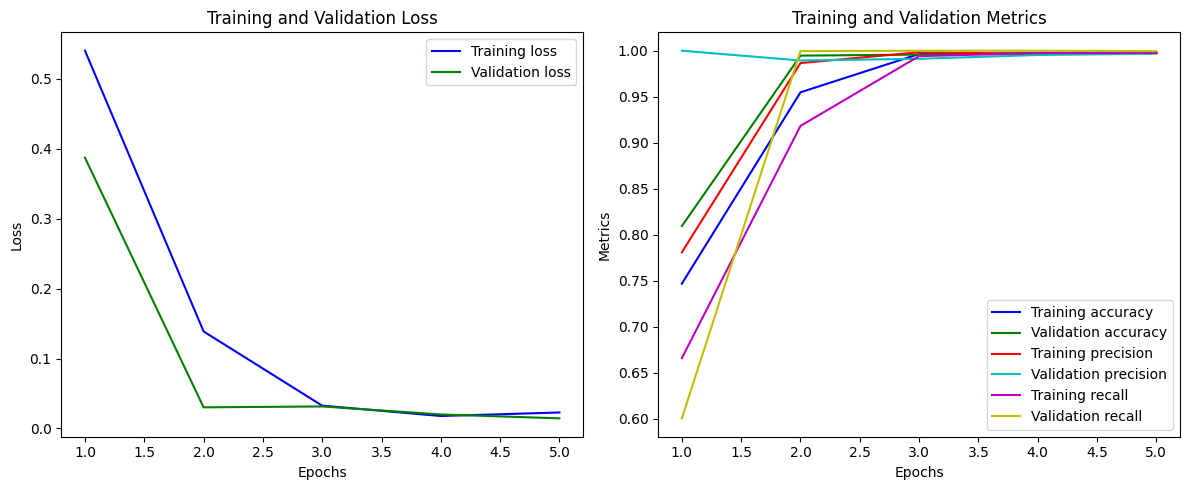

In [25]:
import matplotlib.pyplot as plt

# Extract training history data
train_loss = model_history['loss']
val_loss = model_history['val_loss']
train_accuracy = model_history['Accuracy']
val_accuracy = model_history['val_Accuracy']
train_precision = model_history['Precision']
val_precision = model_history['val_Precision']
train_recall = model_history['Recall']
val_recall = model_history['val_Recall']

# Plot training history
epochs = range(1, len(train_loss) + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Metrics plots
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'c', label='Validation precision')
plt.plot(epochs, train_recall, 'm', label='Training recall')
plt.plot(epochs, val_recall, 'y', label='Validation recall')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()